[reference source](https://data-flair.training/blogs/python-mini-project-speech-emotion-recognition/?fbclid=IwAR0ZRg0Rs_NMn-C31tz21svxF7alY-Tx6Tk_NOIoBr8Qqrp3Q8Fcb7-Vzb4)

4/6/2021

In [ ]:
import librosa
# import soundfile
import os, glob, pickle, sys
import numpy as np

import pandas as pd

from sklearn.neural_network import MLPClassifier

import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## Load Dataset

In [ ]:
Ravdess_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/speech/dataset/ravdess/ravdess_path.csv')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


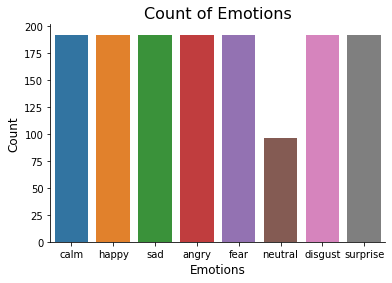

In [ ]:
plt.title('Count of Emotions', size=16)
sns.countplot(Ravdess_df.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

## Feature Extraction

In [ ]:
observed_emotions=sorted(['fear', 'happy', 'sad', 'angry'])

In [ ]:
observed_emotions

['angry', 'fear', 'happy', 'sad']

In [ ]:
num_mfcc=13

In [ ]:
def extract_feature(path, mfcc, chroma, mel, tempo):
  data, sample_rate = librosa.load(path, res_type='kaiser_fast')
  if chroma:
    stft = np.abs(librosa.stft(data))

  result=np.array([])
  if mfcc:
    mfccs=np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=num_mfcc).T, axis=0)
    result=np.hstack((result, mfccs))
  if chroma:
    chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result=np.hstack((result, chroma))
  if mel:
    mel=np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result=np.hstack((result, mel))
  if tempo:
    tempo=np.mean(librosa.feature.tempogram(y=data, sr=sample_rate).T, axis=0)
    result=np.hstack((result, tempo))

  return result

In [ ]:
# def load_data(test_size=0.2):
#   x,y=[],[]
#   for file in glob.glob("/content/drive/MyDrive/Colab Notebooks/speech/dataset/ravdess/Actor_*/*.wav"):
#     file_name=os.path.basename(file)
#     emotion=emotions[file_name.split("-")[2]]
#     if emotion not in observed_emotions:
#         continue
#     feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
#     x.append(feature)
#     y.append(emotion)
#   return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

In [ ]:
X, Y = [], []
for path, emotion in zip(Ravdess_df.Path, Ravdess_df.Emotions):
  if emotion not in observed_emotions:
    continue
  feature = extract_feature(path, mfcc=True, chroma=False, mel=True, tempo=True)
  X.append(feature)
  Y.append(emotion)

In [ ]:
len(X), len(Y), Ravdess_df.Path.shape

(768, 768, (1440,))

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('/content/drive/MyDrive/Colab Notebooks/speech/dataset/ravdess/temp_mfcc_mel_features.csv', index=0)
Features.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,labels
0,-542.508118,54.402779,-13.658027,11.467112,-5.522990,0.883293,-13.780356,-5.889092,-20.672403,-3.965454,-4.639178,-4.446038,-2.538304,0.000008,0.000080,0.000464,0.001942,0.033685,0.239260,0.374652,0.420234,0.099131,0.012808,0.025722,0.068368,0.219898,0.207522,0.280418,0.539812,0.307537,0.155502,0.263589,0.483507,0.300997,0.233112,0.264477,0.416990,0.456977,0.384986,0.179009,...,-3.734611e-17,6.453194e-17,1.691154e-17,5.303013e-17,-2.132890e-17,2.123227e-17,1.393175e-17,2.321580e-17,6.795941e-18,9.193692e-18,-1.358994e-18,4.392269e-17,8.810624e-18,5.532524e-17,-4.857724e-18,5.683435e-17,-4.627983e-17,4.582989e-17,-3.245268e-17,1.420816e-17,6.403324e-18,2.864993e-17,1.874801e-17,-4.286480e-17,4.707281e-17,-3.910225e-17,2.761268e-17,-8.322288e-18,1.934100e-17,-4.494175e-17,7.871954e-17,-3.707398e-17,2.700953e-17,2.593287e-17,-1.582210e-17,4.275779e-17,1.325684e-18,1.507654e-17,1.507481e-17,happy
1,-622.661438,58.430439,-9.114211,17.023947,0.759872,0.289106,-9.672384,-6.628329,-20.923655,-2.678802,-4.249349,-5.525171,-1.133821,0.000001,0.000016,0.000329,0.010903,0.074169,0.124947,0.133783,0.016098,0.018285,0.052441,0.083073,0.033742,0.067630,0.127787,0.122495,0.192502,0.132279,0.053741,0.064878,0.103478,0.220608,0.117464,0.024270,0.009286,0.008385,0.023685,0.027281,...,-3.169278e-17,6.655589e-17,1.389399e-17,3.772211e-17,-7.566097e-18,2.632952e-17,1.290059e-17,2.385455e-17,8.670609e-18,2.285317e-17,1.200658e-18,5.294164e-17,8.510281e-18,4.050176e-17,-6.615700e-18,4.813192e-17,-4.515122e-17,4.916996e-17,-3.782390e-17,1.885078e-17,-2.347669e-18,2.622868e-17,2.529666e-17,-3.680195e-17,2.625130e-17,-4.013103e-17,2.030790e-17,-7.108426e-18,2.296843e-17,-5.197880e-17,6.043015e-17,-2.176813e-17,3.269775e-17,1.253088e-17,-6.904360e-18,4.089239e-17,-9.300289e-18,1.876983e-17,1.719912e-17,sad
2,-405.536560,35.899506,-21.589775,10.615099,-12.247245,1.386372,-16.413448,-4.795670,-21.391001,-2.505552,-7.871837,-5.305902,-6.280683,0.002326,0.001501,0.001673,0.003428,0.042046,0.262092,0.561856,0.804515,1.015966,2.943118,5.422922,3.608459,2.336018,2.385839,1.647708,1.484166,0.442627,0.757970,2.124578,5.486774,4.302755,2.505256,1.347026,1.708984,0.673048,0.894161,1.090497,...,7.224722e-08,5.732959e-08,4.509759e-08,3.513531e-08,2.707811e-08,2.061007e-08,1.546064e-08,1.140037e-08,8.236882e-09,5.810161e-09,3.985338e-09,2.645534e-09,1.689206e-09,1.029196e-09,5.919389e-10,3.166232e-10,1.542208e-10,6.635029e-11,2.409112e-11,6.856975e-12,1.321486e-12,1.136542e-13,4.267823e-17,-4.537954e-17,5.595816e-17,-5.368287e-17,3.464886e-17,-1.642577e-17,3.495048e-17,-4.935990e-17,8.943410e-17,-3.226123e-17,4.087913e-17,2.567693e-17,1.564107e-19,5.019410e-17,1.219639e-18,2.315104e-17,2.976570e-17,angry
3,-627.439819,65.294777,-8.142694,20.094799,2.217384,4.312598,-8.066018,-6.686984,-14.164406,2.684235,-3.951849,1.511707,-2.152171,0.000267,0.000094,0.000968,0.035631,0.191875,0.053334,0.003884,0.003720,0.049795,0.203631,0.059680,0.030760,0.011082,0.061688,0.148226,0.052766,0.059522,0.073923,0.124947,0.115085,0.015583,0.003728,0.030241,0.060317,0.033306,0.004509,0.002097,...,-3.874506e-17,5.719856e-17,1.205596e-17,3.770496e-17,-1.756659e-17,1.907718e-17,7.882742e-18,1.586450e-17,6.692206e-18,1.680508e-17,-2.401926e-18,5.503119e-17,1.237641e-17,3.657600e-17,-1.293922e-17,4.330203e-17,-4.051145e-17,4.459077e-17,-3.339201e-17,1.343793e-17,1.581917e-18,1.405179e-17,1.757829e-17,-3.549109e-17,3.394709e-17,-4.093304e-17,1.092685e-17,-2.281932e-18,1.480616e-17,-5.016810e-17,6.776955e-17,-2.791640e-17,3.576502e-17,7.930375e-18,-1.094875e-17,4.298573e-17,-4.057661e-18,1.269712e-17,1.147035e-17,fear
4,-529.751282,45.074440,-10.304814,12.880028,-8.027542,0.794448,-11.269848,-4.601147,-16.828745,-3.150034

## Data Preparation

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/speech/dataset/ravdess/temp_mfcc_mel_features.csv')
dataset.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,labels
0,-542.508118,54.402779,-13.658027,11.467112,-5.522990,0.883293,-13.780356,-5.889092,-20.672403,-3.965454,-4.639178,-4.446038,-2.538304,0.000008,0.000080,0.000464,0.001942,0.033685,0.239260,0.374652,0.420234,0.099131,0.012808,0.025722,0.068368,0.219898,0.207522,0.280418,0.539812,0.307537,0.155502,0.263589,0.483507,0.300997,0.233112,0.264477,0.416990,0.456977,0.384986,0.179009,...,-3.734611e-17,6.453194e-17,1.691154e-17,5.303013e-17,-2.132890e-17,2.123227e-17,1.393175e-17,2.321580e-17,6.795941e-18,9.193692e-18,-1.358994e-18,4.392269e-17,8.810624e-18,5.532524e-17,-4.857724e-18,5.683435e-17,-4.627983e-17,4.582989e-17,-3.245268e-17,1.420816e-17,6.403324e-18,2.864993e-17,1.874801e-17,-4.286480e-17,4.707281e-17,-3.910225e-17,2.761268e-17,-8.322288e-18,1.934100e-17,-4.494175e-17,7.871954e-17,-3.707398e-17,2.700953e-17,2.593287e-17,-1.582210e-17,4.275779e-17,1.325684e-18,1.507654e-17,1.507481e-17,happy
1,-622.661438,58.430439,-9.114211,17.023947,0.759872,0.289106,-9.672384,-6.628329,-20.923655,-2.678802,-4.249349,-5.525171,-1.133821,0.000001,0.000016,0.000329,0.010903,0.074169,0.124947,0.133783,0.016098,0.018285,0.052441,0.083073,0.033742,0.067630,0.127787,0.122495,0.192502,0.132279,0.053741,0.064878,0.103478,0.220608,0.117464,0.024270,0.009286,0.008385,0.023685,0.027281,...,-3.169278e-17,6.655589e-17,1.389399e-17,3.772211e-17,-7.566097e-18,2.632952e-17,1.290059e-17,2.385455e-17,8.670609e-18,2.285317e-17,1.200658e-18,5.294164e-17,8.510281e-18,4.050176e-17,-6.615700e-18,4.813192e-17,-4.515122e-17,4.916996e-17,-3.782390e-17,1.885078e-17,-2.347669e-18,2.622868e-17,2.529666e-17,-3.680195e-17,2.625130e-17,-4.013103e-17,2.030790e-17,-7.108426e-18,2.296843e-17,-5.197880e-17,6.043015e-17,-2.176813e-17,3.269775e-17,1.253088e-17,-6.904360e-18,4.089239e-17,-9.300289e-18,1.876983e-17,1.719912e-17,sad
2,-405.536560,35.899506,-21.589775,10.615099,-12.247245,1.386372,-16.413448,-4.795670,-21.391001,-2.505552,-7.871837,-5.305902,-6.280683,0.002326,0.001501,0.001673,0.003428,0.042046,0.262092,0.561856,0.804515,1.015966,2.943118,5.422922,3.608459,2.336018,2.385839,1.647708,1.484166,0.442627,0.757970,2.124578,5.486774,4.302755,2.505256,1.347026,1.708984,0.673048,0.894161,1.090497,...,7.224722e-08,5.732959e-08,4.509759e-08,3.513531e-08,2.707811e-08,2.061007e-08,1.546064e-08,1.140037e-08,8.236882e-09,5.810161e-09,3.985338e-09,2.645534e-09,1.689206e-09,1.029196e-09,5.919389e-10,3.166232e-10,1.542208e-10,6.635029e-11,2.409112e-11,6.856975e-12,1.321486e-12,1.136542e-13,4.267823e-17,-4.537954e-17,5.595816e-17,-5.368287e-17,3.464886e-17,-1.642577e-17,3.495048e-17,-4.935990e-17,8.943410e-17,-3.226123e-17,4.087913e-17,2.567693e-17,1.564107e-19,5.019410e-17,1.219639e-18,2.315104e-17,2.976570e-17,angry
3,-627.439819,65.294777,-8.142694,20.094799,2.217384,4.312598,-8.066018,-6.686984,-14.164406,2.684235,-3.951849,1.511707,-2.152171,0.000267,0.000094,0.000968,0.035631,0.191875,0.053334,0.003884,0.003720,0.049795,0.203631,0.059680,0.030760,0.011082,0.061688,0.148226,0.052766,0.059522,0.073923,0.124947,0.115085,0.015583,0.003728,0.030241,0.060317,0.033306,0.004509,0.002097,...,-3.874506e-17,5.719856e-17,1.205596e-17,3.770496e-17,-1.756659e-17,1.907718e-17,7.882742e-18,1.586450e-17,6.692206e-18,1.680508e-17,-2.401926e-18,5.503119e-17,1.237641e-17,3.657600e-17,-1.293922e-17,4.330203e-17,-4.051145e-17,4.459077e-17,-3.339201e-17,1.343793e-17,1.581917e-18,1.405179e-17,1.757829e-17,-3.549109e-17,3.394709e-17,-4.093304e-17,1.092685e-17,-2.281932e-18,1.480616e-17,-5.016810e-17,6.776955e-17,-2.791640e-17,3.576502e-17,7.930375e-18,-1.094875e-17,4.298573e-17,-4.057661e-18,1.269712e-17,1.147035e-17,fear
4,-529.751282,45.074440,-10.304814,12.880028,-8.027542,0.794448,-11.269848,-4.601147,-16.828745,-3.150034

In [ ]:
dataset.labels.value_counts()

fear     192
happy    192
sad      192
angry    192
Name: labels, dtype: int64

## Modeling

### MLPClassifier

In [ ]:
X = dataset.iloc[:, :-1].values
Y = dataset.iloc[:, -1].values

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(np.array(X), Y, test_size = 0.25, random_state = 9)

In [ ]:
x_train.shape

(576, 525)

In [ ]:
model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

In [ ]:
model.fit(x_train, y_train)

MLPClassifier(activation='relu', alpha=0.01, batch_size=256, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(300,), learning_rate='adaptive',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

### LightGBM

In [ ]:
data = dataset.copy()
data.labels = data.labels.map({'angry':0, 'fear':1, 'happy':2, 'sad':3})

In [ ]:
data.labels.value_counts()

3    192
2    192
1    192
0    192
Name: labels, dtype: int64

In [ ]:
X = data.iloc[:, :-1].values
Y = data.iloc[:, -1].values

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state = 0)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=0)

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_valid = sc.transform(x_valid)

In [ ]:
NUM_CLASS = 4

params = {}
params['learning_rate'] = 0.01
params['boosting_type'] = 'gbdt'
params['objective'] = 'multiclass'
params['metric'] = 'multi_logloss'
params['num_leaves'] = 100
params['min_data'] = 100
params['max_depth'] = 50
params['num_class'] = NUM_CLASS
params['max_bin'] = 150 # small max_bin causes faster speed and large value improves accuracy
params['bagging_freq'] = 100
params['feature_fraction'] = 0.6 # deal with column
params['bagging_fraction'] = 0.6
# params['device'] = 'gpu'
#params['num_iterations'] = 1000
#params['early_stopping_rounds'] = 100# the rule of thumb is to have it at 10% of your num_iterations

In [ ]:
x_test.shape

(192, 525)

In [ ]:
import lightgbm as lgb

In [ ]:
dtrain = lgb.Dataset(x_train, y_train)
dvalid = lgb.Dataset(x_valid, y_valid)
lgb_model = lgb.train(params, 
                          dtrain, 
                          num_boost_round=10000,
                          early_stopping_rounds=1000,
                          valid_sets=(dtrain, dvalid), 
                          valid_names=('train','valid'),
                          verbose_eval = 100)

Training until validation scores don't improve for 1000 rounds.
[100]	train's multi_logloss: 1.17049	valid's multi_logloss: 1.28773
[200]	train's multi_logloss: 1.06212	valid's multi_logloss: 1.25034
[300]	train's multi_logloss: 0.991832	valid's multi_logloss: 1.22281
[400]	train's multi_logloss: 0.932602	valid's multi_logloss: 1.20796
[500]	train's multi_logloss: 0.878905	valid's multi_logloss: 1.19234
[600]	train's multi_logloss: 0.834045	valid's multi_logloss: 1.16677
[700]	train's multi_logloss: 0.797901	valid's multi_logloss: 1.16157
[800]	train's multi_logloss: 0.768576	valid's multi_logloss: 1.13779
[900]	train's multi_logloss: 0.734627	valid's multi_logloss: 1.12671
[1000]	train's multi_logloss: 0.709474	valid's multi_logloss: 1.14137
[1100]	train's multi_logloss: 0.686963	valid's multi_logloss: 1.16322
[1200]	train's multi_logloss: 0.65643	valid's multi_logloss: 1.13366
[1300]	train's multi_logloss: 0.635987	valid's multi_logloss: 1.12744
[1400]	train's multi_logloss: 0.61156	

## Experiment results

### MLP

In [ ]:
preds = loaded_model.predict(x_test)

In [ ]:
results = pd.DataFrame()
results['Actual'] = y_test
results['Predicted'] = preds

results.head()

,Actual,Predicted
0,sad,sad
1,sad,sad
2,angry,happy
3,happy,sad
4,fear,angry


In [ ]:
d = results[(results.Actual=='sad') & (results.Predicted=='sad')]
d.shape

(42, 2)

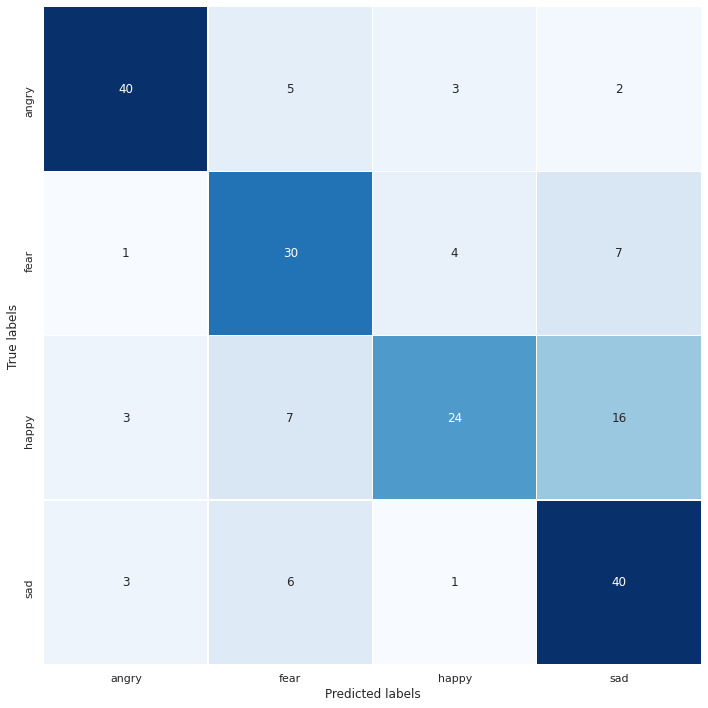

In [ ]:
cm = confusion_matrix(y_test, preds)
df_cm = pd.DataFrame(cm,
                     index=observed_emotions,
                     columns=observed_emotions)
plt.figure(figsize=(10, 10))

sns.set(font_scale=1)


ax = sns.heatmap(df_cm, annot=True, square=True, fmt='d', linewidths=.2, cbar=0, cmap=plt.cm.Blues)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.tight_layout()

name = 'tempo_mel_MFCCs feature 70%.png'
# plt.savefig('/content/drive/MyDrive/Colab Notebooks/speech/dataset/ravdess/Confusion matrix/mlp Confusion matrix for ' + name)

plt.show()

In [ ]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

       angry       0.85      0.80      0.82        50
        fear       0.62      0.71      0.67        42
       happy       0.75      0.48      0.59        50
         sad       0.62      0.80      0.70        50

    accuracy                           0.70       192
   macro avg       0.71      0.70      0.69       192
weighted avg       0.71      0.70      0.69       192



In [ ]:
import pickle

filename = 'tempo_mel_mfcc_MLP_0.7.sav'
# pickle.dump(model, open('/content/drive/MyDrive/Colab Notebooks/speech/dataset/ravdess/Models/' + filename, 'wb'))
loaded_model = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/speech/dataset/ravdess/Models/' + filename, 'rb'))

### LGB

In [ ]:
preds = lgb_model.predict(x_test)

In [ ]:
predictions = []

for x in preds:
    predictions.append(np.argmax(x))

In [ ]:
results = pd.DataFrame()
results['Actual'] = y_test
results['Predicted'] = predictions

results['Actual'] = results['Actual'].map({0:'angry', 1:'fear', 2:'happy', 3:'sad'})
results['Predicted'] = results['Predicted'].map({0:'angry', 1:'fear', 2:'happy', 3:'sad'})
results.head()

,Actual,Predicted
0,fear,angry
1,fear,fear
2,fear,fear
3,angry,happy
4,sad,happy


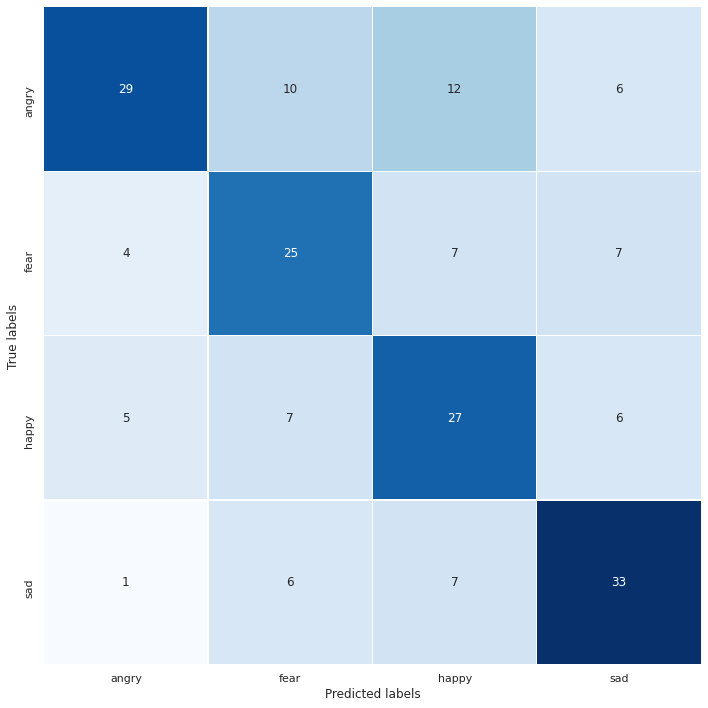

In [ ]:
cm = confusion_matrix(y_test, predictions)
df_cm = pd.DataFrame(cm,
                     index=observed_emotions,
                     columns=observed_emotions)

plt.figure(figsize=(10, 10))

sns.set(font_scale=1)

ax = sns.heatmap(df_cm, annot=True, square=True, fmt='d', linewidths=.2, cbar=0, cmap=plt.cm.Blues)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.tight_layout()

name = 'tempo_mel_MFCCs feature 59%.png'
plt.savefig('/content/drive/MyDrive/Colab Notebooks/speech/dataset/ravdess/Confusion matrix/lgbm Confusion matrix for ' + name)

plt.show()

In [ ]:
print(classification_report(y_test, predictions, target_names=observed_emotions))

              precision    recall  f1-score   support

       angry       0.74      0.51      0.60        57
        fear       0.52      0.58      0.55        43
       happy       0.51      0.60      0.55        45
         sad       0.63      0.70      0.67        47

    accuracy                           0.59       192
   macro avg       0.60      0.60      0.59       192
weighted avg       0.61      0.59      0.59       192



In [ ]:
import pickle

filename = 'tempo_mel_mfcc_lgbm_0.59.sav'
pickle.dump(lgb_model, open('/content/drive/MyDrive/Colab Notebooks/speech/dataset/ravdess/Models/' + filename, 'wb'))
loaded_model = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/speech/dataset/ravdess/Models/' + filename, 'rb'))